In [25]:
import numpy as np
import functools

def operation_counter(func):
    
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        # Initialize operation counter
        wrapper.counter = {'dot': 0, 'mul': 0, 'sub': 0, 'div': 0, 'norm': 0}
        
        # Redefine operations
        original_dot = np.dot
        original_mul = np.multiply
        original_sub = np.subtract
        original_div = np.divide
        original_norm = np.linalg.norm

        np.dot = lambda *args, **kwargs: increment_counter('dot', original_dot, *args, **kwargs)
        np.multiply = lambda *args, **kwargs: increment_counter('mul', original_mul, *args, **kwargs)
        np.subtract = lambda *args, **kwargs: increment_counter('sub', original_sub, *args, **kwargs)
        np.divide = lambda *args, **kwargs: increment_counter('div', original_div, *args, **kwargs)
        np.linalg.norm = lambda *args, **kwargs: increment_counter('norm', original_norm, *args, **kwargs)
        
        # Helper function to increment counter and perform operation
        def increment_counter(op, original_func, *args, **kwargs):
            wrapper.counter[op] += 1
            return original_func(*args, **kwargs)
        
        # Execute the function and count operations
        result = func(*args, **kwargs)
        
        # Restore original operations
        np.dot = original_dot
        np.multiply = original_mul
        np.subtract = original_sub
        np.divide = original_div
        np.linalg.norm = original_norm
        
        # Compute total operation count
        n = args[0].shape[0]
        total_operations = (2*n-1)*wrapper.counter['dot'] + n*(wrapper.counter['mul'] + wrapper.counter['sub'] + wrapper.counter['div'] + wrapper.counter['norm'])
        
        # Print operation count
        print(f"Operation counts: {wrapper.counter}")
        print(f"Total operation count estimate: {total_operations}")
        print("Derivation: from dot: {}*{} mul + {}*{} addition, from mul: {}*{} mul, from sub: {}*{} sub, from div: {}*{} div, from norm: {}*{} norm = {}"
            .format(wrapper.counter['dot'], (2*n-1), wrapper.counter['dot'], (n-1), wrapper.counter['mul'], n,
                    wrapper.counter['sub'], n, wrapper.counter['div'], n, wrapper.counter['norm'], n, total_operations))
        
        return result

    return wrapper

## The algorithm

In [26]:
@operation_counter
def modified_gram_schmidt(V):
    """
    Implements the Modified Gram-Schmidt algorithm.

    Parameters:
        V (numpy array): The input matrix.

    Returns:
        Q (numpy array): The orthogonal matrix.
        R (numpy array): The upper triangular matrix.
    """
    m, n = V.shape
    Q = np.zeros((m, n))
    R = np.zeros((n, n))

    for j in range(n):
        vj = V[:, j]
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], V[:, j])
            vj = np.subtract(vj, np.multiply(R[i, j], Q[:, i]))
        R[j, j] = np.linalg.norm(vj)
        Q[:, j] = np.divide(vj, R[j, j])

    return Q, R

In [27]:
# A 3x3 example matrix
A = np.array([[12, -51, 4], [6, 167, -68], [-4, 24, -41]], dtype=float)

print("Original Matrix (A):")
print(A)

Q, R = modified_gram_schmidt(A)

print("Orthogonal Matrix (Q):")
print(Q)

print("Upper Triangular Matrix (R):")
print(R)

# Verifying that QR = A
print("Product QR:")
print(np.dot(Q, R))

# Verifying the orthogonality of Q
print("Q^TQ (should be identity):")
print(np.dot(Q.T, Q))

# Compute the Frobenius norm of (A - QR) which should be close to zero
# It measures the difference between A and the product QR
print("Frobenius norm of (A - QR) (should be close to zero):")
print(np.linalg.norm(A - np.dot(Q, R)))

# Compute the 2-norm of (I - Q^T*Q) which should be close to zero
# It measures the difference between I and Q^TQ (Q^TQ should be I since Q is orthogonal)
print("2-norm of (I - Q^T*Q) (To see orthongonality of Q, should be close to zero):")
print(np.linalg.norm(np.eye(Q.shape[1]) - np.dot(Q.T, Q)))

Original Matrix (A):
[[ 12. -51.   4.]
 [  6. 167. -68.]
 [ -4.  24. -41.]]
Operation counts: {'dot': 3, 'mul': 3, 'sub': 3, 'div': 3, 'norm': 3}
Total operation count estimate: 51
Derivation: from dot: 3*5 mul + 3*2 addition, from mul: 3*3 mul, from sub: 3*3 sub, from div: 3*3 div, from norm: 3*3 norm = 51
Orthogonal Matrix (Q):
[[ 0.85714286 -0.39428571 -0.33142857]
 [ 0.42857143  0.90285714  0.03428571]
 [-0.28571429  0.17142857 -0.94285714]]
Upper Triangular Matrix (R):
[[ 14.  21. -14.]
 [  0. 175. -70.]
 [  0.   0.  35.]]
Product QR:
[[ 12. -51.   4.]
 [  6. 167. -68.]
 [ -4.  24. -41.]]
Q^TQ (should be identity):
[[ 1.00000000e+00 -2.08166817e-17 -1.11022302e-16]
 [-2.08166817e-17  1.00000000e+00 -8.32667268e-17]
 [-1.11022302e-16 -8.32667268e-17  1.00000000e+00]]
Frobenius norm of (A - QR) (should be close to zero):
0.0
2-norm of (I - Q^T*Q) (To see orthongonality of Q, should be close to zero):
2.5305566709891245e-16


## Operation count


Matrix size: 2
Operation counts: {'dot': 1, 'mul': 1, 'sub': 1, 'div': 2, 'norm': 2}
Total operation count estimate: 15
Derivation: from dot: 1*3 mul + 1*1 addition, from mul: 1*2 mul, from sub: 1*2 sub, from div: 2*2 div, from norm: 2*2 norm = 15

Matrix size: 3
Operation counts: {'dot': 3, 'mul': 3, 'sub': 3, 'div': 3, 'norm': 3}
Total operation count estimate: 51
Derivation: from dot: 3*5 mul + 3*2 addition, from mul: 3*3 mul, from sub: 3*3 sub, from div: 3*3 div, from norm: 3*3 norm = 51

Matrix size: 4
Operation counts: {'dot': 6, 'mul': 6, 'sub': 6, 'div': 4, 'norm': 4}
Total operation count estimate: 122
Derivation: from dot: 6*7 mul + 6*3 addition, from mul: 6*4 mul, from sub: 6*4 sub, from div: 4*4 div, from norm: 4*4 norm = 122

Matrix size: 5
Operation counts: {'dot': 10, 'mul': 10, 'sub': 10, 'div': 5, 'norm': 5}
Total operation count estimate: 240
Derivation: from dot: 10*9 mul + 10*4 addition, from mul: 10*5 mul, from sub: 10*5 sub, from div: 5*5 div, from norm: 5*5 norm

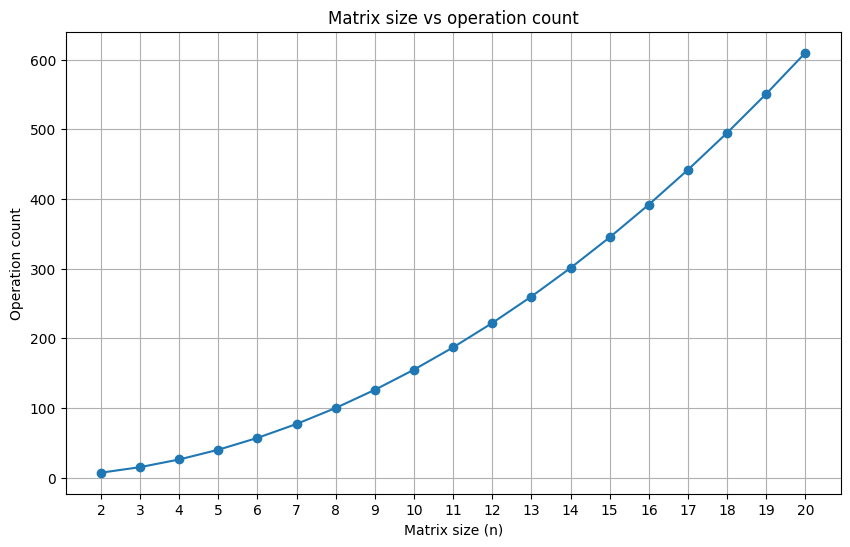

In [28]:
import matplotlib.pyplot as plt

# Initialize lists to store matrix sizes and operation counts
matrix_sizes = []
operation_counts = []

# Iterate over different matrix sizes
for n in range(2, 21):  # Modify the range as required
    print(f"\nMatrix size: {n}")

    # Create a n x n example matrix filled with random numbers
    A = np.random.rand(n, n)

    # Run the modified Gram-Schmidt algorithm
    Q, R = modified_gram_schmidt(A)

    # Store the matrix size and total operation count
    matrix_sizes.append(n)
    operation_counts.append(sum(modified_gram_schmidt.counter.values()))

# Plot matrix size versus operation count
plt.figure(figsize=(10, 6))
plt.plot(matrix_sizes, operation_counts, marker='o')
plt.title('Matrix size vs operation count')
plt.xlabel('Matrix size (n)')
plt.ylabel('Operation count')
plt.grid(True)
plt.xticks(np.arange(min(matrix_sizes), max(matrix_sizes) + 1, 1)) 
plt.show()

## Verify big-O notation (operation count growth rate) of the algorithm

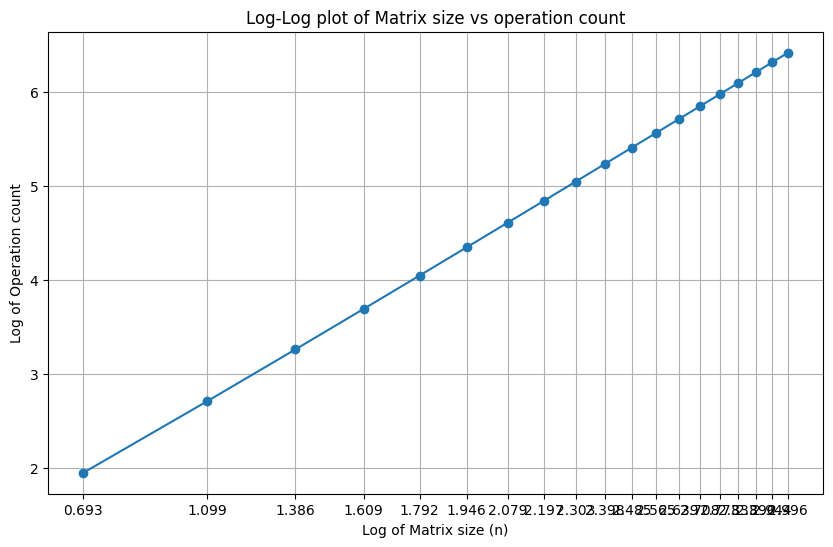

Estimated slope on log-log plot: 1.9402317949965104


In [29]:
import numpy as np

# Convert your data to a numpy array for easy calculations
matrix_sizes_np = np.array(matrix_sizes)
operation_counts_np = np.array(operation_counts)

# Calculate the log of your data
log_matrix_sizes = np.log(matrix_sizes_np)
log_operation_counts = np.log(operation_counts_np)

# Plot the log-log plot
plt.figure(figsize=(10, 6))
plt.plot(log_matrix_sizes, log_operation_counts, marker='o')
plt.title(f'Log-Log plot of Matrix size vs operation count')
plt.xlabel('Log of Matrix size (n)')
plt.ylabel('Log of Operation count')
plt.grid(True)
plt.xticks(log_matrix_sizes)  # If you still want the x-axis to show integers, but in the log scale.
plt.show()

# Calculate the slope of the line in the log-log plot, which should be approximately 3 for a cubic behavior
slope = (log_operation_counts[-1] - log_operation_counts[0]) / (log_matrix_sizes[-1] - log_matrix_sizes[0])
print(f"Estimated slope on log-log plot: {slope}")

The result is approximate to $O(n^2)$, which is close to the threoetical operation cost $\sum_{j=1}^n j(4m) \approx 2mn^2$. 